# Define and train a symbol classifier

In [1]:
import os
import sys
import time
import copy
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 2060


In [8]:
# to globaly disable print if necessary	
devnullFile = open(os.devnull,"w")
printStream = sys.stdout

In [11]:
DATA_FOLDER = r'../../data/trainingSymbolsGT/'

print(os.listdir(DATA_FOLDER))

['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'a', 'alpha', 'A_', 'b', 'beta', 'B_', 'c', 'cos', 'C_', 'd', 'Delta', 'div', 'div_op', 'dot', 'e', 'exists', 'E_', 'f', 'forall', 'F_', 'g', 'gamma', 'geq', 'gt', 'G_', 'h', 'H_', 'i', 'in', 'infty', 'int', 'I_', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'L_', 'm', 'mu', 'M_', 'n', 'neq', 'N_', 'o', 'p', 'phi', 'pi', 'pipe', 'pm', 'prime', 'P_', 'q', 'r', 'rightarrow', 'R_', 's', 'sigma', 'sin', 'sqrt', 'sum', 'S_', 't', 'tan', 'theta', 'times', 'T_', 'u', 'v', 'V_', 'w', 'x', 'X_', 'y', 'Y_', 'z', '[', ']', '{', '}']


### Préparation des données

In [12]:
# Transformation appliquée aux images
transform = transforms.Compose(
    [transforms.Grayscale(),  # Convertir les images RGB en niveaux de gris
     transforms.ToTensor(),   # Convertir les images en tensors PyTorch
     transforms.Normalize((0.5,), (0.5,))]  # Normaliser les images
)

# Taille du minibatch pour l'entraînement
minibatchsize = 128

# Création d'un ensemble de données complet à partir du dossier spécifié
fulltrainset = torchvision.datasets.ImageFolder(root=DATA_FOLDER, transform=transform)

# Répartition des données en ensembles de formation, de validation et de test
seed = 42  # Seed pour la reproductibilité
a_part = int(len(fulltrainset) / 5)
trainset, validationset, testset = torch.utils.data.random_split(fulltrainset, 
                                                                 [3 * a_part, a_part, len(fulltrainset) - 4 * a_part],
                                                                 generator=torch.Generator().manual_seed(seed))

# Création des chargeurs de données pour chaque ensemble
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize,
                                          shuffle=True, drop_last=True, num_workers=1)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize,
                                               shuffle=False, drop_last=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize,
                                         shuffle=False, drop_last=True, num_workers=0)

# Longueur du chargeur d'entraînement et classes
trainloader_len = len(trainloader)
classes = fulltrainset.classes
nb_classes = len(classes)

print(nb_classes)
print(classes)


101
['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A_', 'B_', 'C_', 'Delta', 'E_', 'F_', 'G_', 'H_', 'I_', 'L_', 'M_', 'N_', 'P_', 'R_', 'S_', 'T_', 'V_', 'X_', 'Y_', '[', ']', 'a', 'alpha', 'b', 'beta', 'c', 'cos', 'd', 'div', 'div_op', 'dot', 'e', 'exists', 'f', 'forall', 'g', 'gamma', 'geq', 'gt', 'h', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'm', 'mu', 'n', 'neq', 'o', 'p', 'phi', 'pi', 'pipe', 'pm', 'prime', 'q', 'r', 'rightarrow', 's', 'sigma', 'sin', 'sqrt', 'sum', 't', 'tan', 'theta', 'times', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}']


In [13]:
def Train(net , optimizer , criterion ,  num_epochs = 5 , min_early_stopping = 6):
    # Definition of arrays to store the results and draw the learning curves
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    # best system results
    best_val_loss = 1000000
    best_nb_sample = 0
    best_model =  copy.deepcopy(net)

    nb_used_sample = 0
    running_loss = 0.0
    print_every = trainloader_len
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = time.time()
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            # count how many samples have been used during the training
            nb_used_sample += minibatchsize
            # print/save statistics
            running_loss += loss.item()
            if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
                train_err = (running_loss / (print_every * minibatchsize))
                
                print('Epoch %d batch %5d ' % (epoch + 1, i + 1),file=printStream)
                print('Train loss : %.3f' % train_err,file=printStream)
                running_loss = 0.0
                #evaluation on validation set
                
                totalValLoss = 0.0
                net.eval()
                with torch.no_grad():
                    for data in validationloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        
                        outputs = net(images)
                        loss = criterion(outputs, labels)
                        totalValLoss += loss.item()
                net.train()
                val_err = (totalValLoss / len(validationset))
                print('Validation loss mean : %.3f' % val_err,file=printStream)

                # # if the validation error is increasing again, we stop the training here
                # to avoid overfitting
                if epoch > min_early_stopping:
                    print(val_err , val_err_array[-1])
                    if val_err >= ( val_err_array[-1] + 0.001 ) : 
                        print('Early stopping at epoch ({})'.format(epoch),file=printStream)
                        epoch = num_epochs

                if val_err <= best_val_loss:
                    best_val_loss = val_err
                    best_nb_sample = nb_used_sample
                    torch.save(best_model.state_dict(), "./best_model.nn")
                    
                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                # save the model only when loss is better
                best_model =  copy.deepcopy(net)
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time),file=printStream)

    print('Finished Training',file=printStream)

    return {"val_err_array":val_err_array,"train_err_array":train_err_array,"nb_sample_array":nb_sample_array
        , "best_nb_sample" : best_nb_sample , "best_val_loss" : best_val_loss , "best_model" : best_model}
    ### uncomment to save the best model :
    # torch.save(best_model.state_dict(), "./best_model.nn")
    
    ### to load a trained model :
    # model = NetMLP(*args) (must have the same parameters as the saved weights)
    # model.load_state_dict(torch.load(PATH))

In [14]:
def TestEachClass( best_model ):

    # Check the results for each class
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # compute ... and show results

    for i in range(nb_classes):
        if class_total[i] > 0 :
            print('Accuracy of %5s : %2d %% (%d/%d)' % (
                classes[i], 100 * class_correct[i] / class_total[i], class_correct[i] , class_total[i]),file=printStream)
        else:
            print('No %5s sample' % (classes[i]),file=printStream)

def TestWholeTestDS( best_model ):
    # Test now  on the whole test dataset.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = ( 100 * correct / total)
    print('Accuracy of the network on the test images: %d %%' % accuracy,file=printStream)

    return accuracy

def DisplayClassifierResults( results ):

	plt.clf()
	plt.xlabel('epoch')
	plt.ylabel('val / train LOSS')
	plt.title('Digit classifier')
	plt.plot(
		results["nb_sample_array"].tolist()[1:], 
		results["val_err_array"].tolist()[1:], 'b',
		results["nb_sample_array"].tolist()[1:], 
		results["train_err_array"].tolist()[1:], 'r',
		results["best_nb_sample"],
		results["best_val_loss"],'go')
	plt.show()  

def Run( net ,  num_epochs , disablePloting = False):
	net.to(device)
	criterion = nn.CrossEntropyLoss()
	optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

	results = Train( net , optimizer , criterion , num_epochs= num_epochs)

	if not disablePloting:
		DisplayClassifierResults(results)

	results["accuracy"] = TestWholeTestDS(results["best_model"])

	TestEachClass(results["best_model"])

	return results

def TrainAndReturn(net, num_epochs,min_early_stopping):
	net.to(device)
	criterion = nn.CrossEntropyLoss()
	optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

	return Train( net , optimizer , criterion , num_epochs= num_epochs , min_early_stopping = min_early_stopping)

def TrainAndGetAccuracy( net ,  num_epochs):
	net.to(device)
	criterion = nn.CrossEntropyLoss()
	optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

	results = Train( net , optimizer , criterion , num_epochs= num_epochs)

	return TestWholeTestDS(results["best_model"])

In [15]:
# ploting the confusion matrix
def ConfusionMatrix( best_model ):

    # Check the results for each class

	y_pred = []
	y_true = []

	conf_matrix =  np.zeros([nb_classes, nb_classes])
	with torch.no_grad():
		for data in testloader:
			images, labels = data
			images, labels = images.to(device), labels.to(device)
			output = best_model(images)
			output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
			y_pred.extend(output) # Save Prediction
			labels = labels.data.cpu().numpy()
			y_true.extend(labels) # Save Truth


			
# Build confusion matrix

	for (pred,true) in zip(y_pred,y_true):
		conf_matrix[pred][true] += 1

	df_cm = pd.DataFrame(conf_matrix, index = [i for i in classes],columns = [i for i in classes])
	plt.figure(figsize = (12,7))
	sn.heatmap(df_cm, annot=True)

In [16]:
class TestCNN(nn.Module):
    def __init__(self , fcLayerSize , n_filters , kernel_size , layers , dropout = False):
        super(TestCNN, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        
        setattr(self,"conv0",nn.Conv2d(1 , n_filters , kernel_size))
        for i in range(layers-1):
            setattr(self,"conv"+str(i + 1),nn.Conv2d(n_filters , n_filters , kernel_size))
        
        self.layers = layers

        self.dropout = nn.Dropout(0.5 * dropout)

        self.fc1 = nn.Linear(fcLayerSize, 256)
        self.fc2 = nn.Linear(256, 200)
        self.fc3 = nn.Linear(200, nb_classes)

    def forward(self, x):
        for i in range(self.layers):
            x = self.pool(F.relu(getattr(self,"conv"+str(i))(x)) )

        x = x.view(minibatchsize,-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        return x

### Definition of parameters

In [34]:
filters = 128
kernel_size = 3
layers = 3
dropout = True
fcLayerSize = 512

#fcLayerSize = 0
#fcLayerSize = ComputeFCFirstFeatureIn( filters , kernel_size , layers )
#print(fcLayerSize)
net =  TestCNN(fcLayerSize  , filters , kernel_size , layers , dropout=dropout)

#Run(net, 6)

results = TrainAndReturn( net , num_epochs = 20 , min_early_stopping = 0)


Epoch 1 batch   402 
Train loss : 0.020
Validation loss mean : 0.007
Epoch 1 of 20 took 796.822s
Epoch 2 batch   402 
Train loss : 0.007
Validation loss mean : 0.005
0.004703923780253995 0.007472503879965046
Epoch 2 of 20 took 40.070s
Epoch 3 batch   402 
Train loss : 0.005
Validation loss mean : 0.004
0.003741234157989909 0.004703923780253995
Epoch 3 of 20 took 39.847s
Epoch 4 batch   402 
Train loss : 0.005
Validation loss mean : 0.003
0.0033341574493474337 0.003741234157989909
Epoch 4 of 20 took 39.778s
Epoch 5 batch   402 
Train loss : 0.004
Validation loss mean : 0.003
0.0031198133981519644 0.0033341574493474337
Epoch 5 of 20 took 43.455s
Epoch 6 batch   402 
Train loss : 0.004
Validation loss mean : 0.003
0.0030640431859971203 0.0031198133981519644
Epoch 6 of 20 took 41.641s
Epoch 7 batch   402 
Train loss : 0.003
Validation loss mean : 0.003
0.002776821582884222 0.0030640431859971203
Epoch 7 of 20 took 42.402s
Epoch 8 batch   402 
Train loss : 0.003
Validation loss mean : 0.003


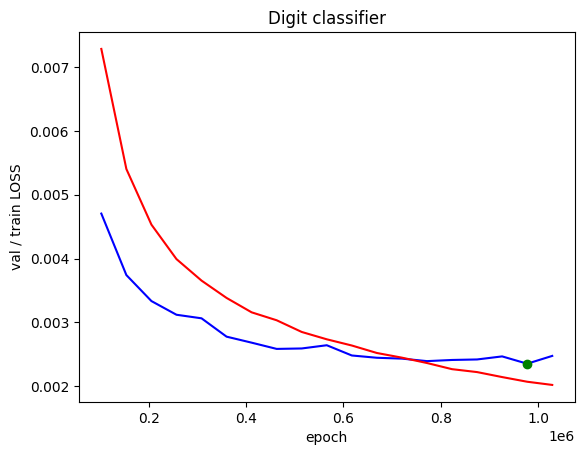

In [36]:
DisplayClassifierResults(results)

In [35]:
#save best model from results
best_model = results["best_model"]
torch.save(best_model.state_dict(), "./best_model.nn")

In [37]:
MODEL_FOLDER  = r'../../models/'

filters = 128
kernel_size = 3
layers = 3
dropout = True
fcLayerSize = 512

#load a trained model
loaded_model = TestCNN(fcLayerSize  , filters , kernel_size , layers , dropout=dropout)
loaded_model.load_state_dict(torch.load(MODEL_FOLDER + "best_model.nn"))

# Déplacer le modèle sur le bon appareil (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)



TestCNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=101, bias=True)
)

In [38]:
#test best model
TestWholeTestDS(loaded_model)

Accuracy of the network on the test images: 89 %


89.01002798507463

In [39]:
TestEachClass(loaded_model)

Accuracy of     ! : 90 % (18/20)
Accuracy of     ( : 95 % (754/788)
Accuracy of     ) : 96 % (794/822)
Accuracy of     + : 97 % (1048/1070)
Accuracy of     , : 34 % (46/132)
Accuracy of     - : 99 % (1637/1644)
Accuracy of     0 : 95 % (355/370)
Accuracy of     1 : 93 % (1124/1208)
Accuracy of     2 : 94 % (1185/1250)
Accuracy of     3 : 95 % (471/491)
Accuracy of     4 : 97 % (308/317)
Accuracy of     5 : 89 % (201/225)
Accuracy of     6 : 95 % (140/146)
Accuracy of     7 : 90 % (131/145)
Accuracy of     8 : 87 % (120/137)
Accuracy of     9 : 78 % (118/151)
Accuracy of     = : 97 % (676/690)
Accuracy of    A_ : 96 % (53/55)
Accuracy of    B_ : 80 % (36/45)
Accuracy of    C_ :  2 % (1/45)
Accuracy of Delta : 57 % (4/7)
Accuracy of    E_ : 86 % (25/29)
Accuracy of    F_ : 96 % (29/30)
Accuracy of    G_ : 66 % (12/18)
Accuracy of    H_ : 76 % (20/26)
Accuracy of    I_ : 75 % (9/12)
Accuracy of    L_ : 87 % (21/24)
Accuracy of    M_ : 73 % (19/26)
Accuracy of    N_ : 92 % (26/28)
Accuracy

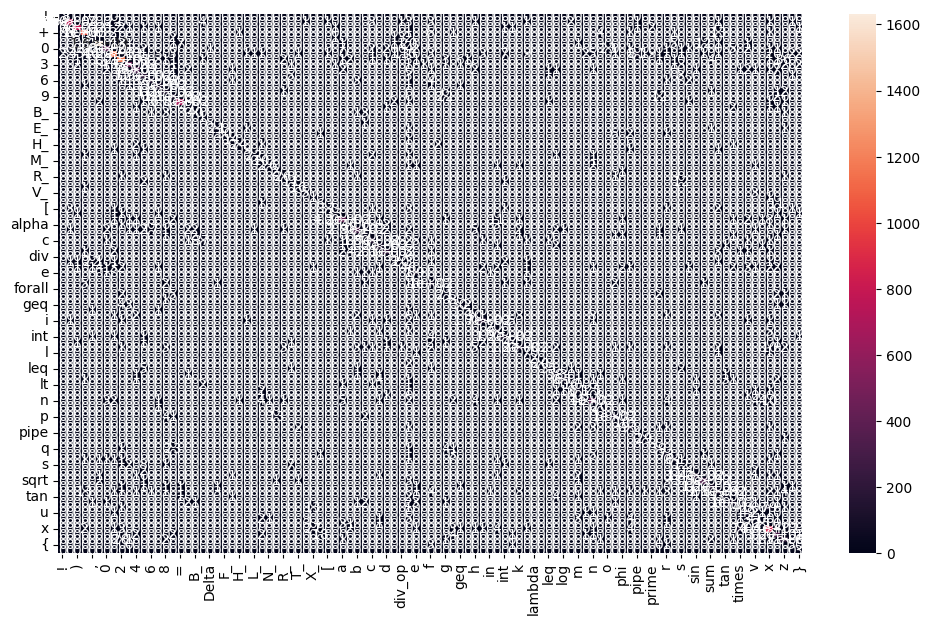

In [33]:
ConfusionMatrix(loaded_model)